# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [191]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 데이터 읽어오기


In [192]:
RANDOM_STATE = 110

train_data = pd.read_csv("../../data/trim_train_data.csv")
test_data = pd.read_csv("../../data/trim_test_data.csv")

In [193]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 464 entries, Wip Line_Dam to target
dtypes: float64(342), int64(88), object(34)
memory usage: 143.4+ MB


In [194]:
# excel 데이터의 각 열에 대한 값의 개수 출력 -> 변수명 확인용도
for col in train_data.columns:
    counts = train_data[col].value_counts()
    print(f"Value counts for column {col}:")
    print(counts)
    print()

Value counts for column Wip Line_Dam:
IVI-OB6    40506
Name: Wip Line_Dam, dtype: int64

Value counts for column Process Desc._Dam:
Dam Dispenser    40506
Name: Process Desc._Dam, dtype: int64

Value counts for column Equipment_Dam:
Dam dispenser #1    25030
Dam dispenser #2    15476
Name: Equipment_Dam, dtype: int64

Value counts for column Model.Suffix_Dam:
AJX75334501    33820
AJX75334502     3390
AJX75334505     2635
AJX75334507      310
AJX75334503      162
AJX75334506      129
AJX75334508       60
Name: Model.Suffix_Dam, dtype: int64

Value counts for column Workorder_Dam:
3L1X8574-2       272
3K1XC268-1       227
3L1X9934-1       217
3L1X8506-1       217
3K1XA586-2       189
                ... 
4BPM0084-1         2
3FPXX064-0003      2
3H1XB714-1         1
4CPM0166-1         1
3HPM0061-1         1
Name: Workorder_Dam, Length: 663, dtype: int64

Value counts for column Insp. Seq No._Dam:
1    40506
Name: Insp. Seq No._Dam, dtype: int64

Value counts for column Insp Judge Code_Da

In [195]:
# 모든 값이 NaN인 열 제거 전 컬럼 이름 저장
train_columns_before = set(train_data.columns)
test_columns_before = set(test_data.columns)

# 모든 값이 NaN인 열 제거
train_data = train_data.dropna(axis=1, how='all')
test_data = test_data.dropna(axis=1, how='all')

# 모든 값이 NaN인 열 제거 후 컬럼 이름 저장
train_columns_after = set(train_data.columns)
test_columns_after = set(test_data.columns)

# 제거된 컬럼 이름 계산
removed_train_columns = train_columns_before - train_columns_after
removed_test_columns = test_columns_before - test_columns_after

# 한 줄에 3개씩 출력하는 함수
def print_columns(columns, title):
    print(title)
    columns = list(columns)
    for i in range(0, len(columns), 3):
        print(", ".join(columns[i:i+3]))

# 제거된 컬럼 이름 출력
print_columns(removed_train_columns, "Removed columns from train_data:")
# print_columns(removed_test_columns, "Removed columns from test_data:")

# 제거 후 데이터 확인
print("All columns with only NaN values have been removed.")

Removed columns from train_data:
DISCHARGED TIME OF RESIN(Stage2) Unit Time_Fill1, HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Dam, DISCHARGED TIME OF RESIN(Stage3) Unit Time_Fill2
Stage1 Line4 Distance Speed Judge Value_Dam, Head Clean Position X Unit Time_Fill1, HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Dam
Stage1 Line2 Distance Speed Judge Value_Dam, Production Qty Judge Value_Dam, Head Purge Position Y Unit Time_Fill2
Stage3 Line4 Distance Speed Judge Value_Dam, Dispense Volume(Stage1) Judge Value_Dam, Head Clean Position Y Judge Value_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Fill1, CURE START POSITION X Judge Value_Dam, CURE STANDBY POSITION Z Unit Time_Dam
CURE START POSITION X Judge Value_Fill2, CURE END POSITION X Unit Time_Fill2, HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Fill2
Head Purge Position Y Unit Time_Dam, Stage1 Line2 Distance Speed Unit Time_Dam, WorkMode Unit Time_Fill1
Head Zero Position Z Judge Value_Dam, HEAD NORMAL COORDINATE Z AX

In [196]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 186 entries, Wip Line_Dam to target
dtypes: float64(64), int64(88), object(34)
memory usage: 57.5+ MB


In [197]:
# # excel 데이터의 각 열에 대한 값의 개수 출력 -> 변수명 확인용도
# for col in train_data.columns:
#     counts = train_data[col].value_counts()
#     print(f"Value counts for column {col}:")
#     print(counts)
#     print()

In [198]:
wip_line_columns = train_data.filter(like='Wip Line').columns

new_df = train_data.filter(items=wip_line_columns)

new_df.value_counts()

Wip Line_Dam  Wip Line_AutoClave  Wip Line_Fill1  Wip Line_Fill2
IVI-OB6       IVI-OB6             IVI-OB6         IVI-OB6           40506
dtype: int64

In [199]:
train_data.drop(columns=wip_line_columns, inplace=True)
test_data.drop(columns=wip_line_columns, inplace=True)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 182 entries, Process Desc._Dam to target
dtypes: float64(64), int64(88), object(30)
memory usage: 56.2+ MB


In [200]:
Process_Desc_col = train_data.filter(like='Process Desc').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Process Desc._Dam  Process Desc._AutoClave  Process Desc._Fill1  Process Desc._Fill2
Dam Dispenser      Auto Clave Out           Fill1 Dispenser      Fill2 Dispenser        40506
dtype: int64

In [201]:
train_data = train_data.drop(columns=['Process Desc._Dam', 'Process Desc._AutoClave', 'Process Desc._Fill1', 'Process Desc._Fill2'])
test_data = test_data.drop(columns=['Process Desc._Dam', 'Process Desc._AutoClave', 'Process Desc._Fill1', 'Process Desc._Fill2'])

In [202]:
# Equipment로 시작하는 열 필터링
Equipment_col = train_data.filter(like='Equipment').columns
new3_df = train_data.filter(items=Equipment_col)

# target 변수 추가
new3_df['target'] = train_data['target']

# 그룹별로 target 변수의 비율 계산
target_ratio = new3_df.groupby(list(Equipment_col))['target'].value_counts(normalize=True).unstack().fillna(0)

# AbNormal 비율 출력
abnormal_ratio = target_ratio.get('AbNormal', 0)
print("각 그룹의 abnormal_ratio:")
print(abnormal_ratio)

# 각 그룹에 값의 갯수 출력
group_counts = new3_df.groupby(list(Equipment_col)).size()
print("각 그룹의 값의 갯수:")
print(group_counts)


각 그룹의 abnormal_ratio:
Equipment_Dam     Equipment_AutoClave  Equipment_Fill1     Equipment_Fill2   
Dam dispenser #1  Auto Clave Out       Fill1 dispenser #1  Fill2 dispenser #1    0.058614
                                                           Fill2 dispenser #2    1.000000
                                       Fill1 dispenser #2  Fill2 dispenser #2    1.000000
Dam dispenser #2  Auto Clave Out       Fill1 dispenser #1  Fill2 dispenser #1    1.000000
                                       Fill1 dispenser #2  Fill2 dispenser #1    1.000000
                                                           Fill2 dispenser #2    0.054977
Name: AbNormal, dtype: float64
각 그룹의 값의 갯수:
Equipment_Dam     Equipment_AutoClave  Equipment_Fill1     Equipment_Fill2   
Dam dispenser #1  Auto Clave Out       Fill1 dispenser #1  Fill2 dispenser #1    25011
                                                           Fill2 dispenser #2        6
                                       Fill1 dispenser #2  Fill2

In [203]:
# Equipment로 시작하는 열 필터링
Equipment_col = train_data.filter(like='Equipment').columns
Equipment_col2 = test_data.filter(like='Equipment').columns

new3_df = train_data.filter(items=Equipment_col)
new3_df2 = test_data.filter(items=Equipment_col2)

# Equipment_same_num 파생변수 생성
def determine_equipment_same_num(row):
    if (row['Equipment_Dam'] == 'Dam dispenser #1' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #1' and row['Equipment_Fill2'] == 'Fill2 dispenser #1') or \
       (row['Equipment_Dam'] == 'Dam dispenser #2' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #2' and row['Equipment_Fill2'] == 'Fill2 dispenser #2'):
        return 1
    else:
        return 0

train_data['Equipment_same_num'] = new3_df.apply(determine_equipment_same_num, axis=1)
test_data['Equipment_same_num'] = new3_df2.apply(determine_equipment_same_num, axis=1)

train_data = train_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])
test_data = test_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])


In [204]:
Process_Desc_col = train_data.filter(like='Model.Suffix').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Model.Suffix_Dam  Model.Suffix_AutoClave  Model.Suffix_Fill1  Model.Suffix_Fill2
AJX75334501       AJX75334501             AJX75334501         AJX75334501           33820
AJX75334502       AJX75334502             AJX75334502         AJX75334502            3390
AJX75334505       AJX75334505             AJX75334505         AJX75334505            2635
AJX75334507       AJX75334507             AJX75334507         AJX75334507             310
AJX75334503       AJX75334503             AJX75334503         AJX75334503             162
AJX75334506       AJX75334506             AJX75334506         AJX75334506             129
AJX75334508       AJX75334508             AJX75334508         AJX75334508              60
dtype: int64

In [205]:
# Model.Suffix_Dam의 이름을 Model.Suffix로 변경
train_data = train_data.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})
test_data = test_data.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})

# Model.Suffix_AutoClave, Model.Suffix_Fill1, Model.Suffix_Fill2 열 드롭
train_data = train_data.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])
test_data = test_data.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])

In [206]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 172 entries, Model.Suffix to Equipment_same_num
dtypes: float64(64), int64(89), object(19)
memory usage: 53.2+ MB


In [207]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Columns: 172 entries, Set ID to Equipment_same_num
dtypes: float64(121), int64(32), object(19)
memory usage: 22.8+ MB


In [208]:
# Workorder로 시작하는 열 필터링
workorder_cols = ['Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2']

# Workorder 열들로 이루어진 데이터프레임 생성
workorder_df = train_data[workorder_cols]

# 4개의 변수의 값이 모두 동일하지 않은 행 필터링
different_workorders = workorder_df[
    (workorder_df['Workorder_Dam'] != workorder_df['Workorder_AutoClave']) |
    (workorder_df['Workorder_Dam'] != workorder_df['Workorder_Fill1']) |
    (workorder_df['Workorder_Dam'] != workorder_df['Workorder_Fill2']) |
    (workorder_df['Workorder_AutoClave'] != workorder_df['Workorder_Fill1']) |
    (workorder_df['Workorder_AutoClave'] != workorder_df['Workorder_Fill2']) |
    (workorder_df['Workorder_Fill1'] != workorder_df['Workorder_Fill2'])
]

# 결과 출력
print("4개의 변수의 값이 모두 동일하지 않은 경우:")
print(different_workorders)

4개의 변수의 값이 모두 동일하지 않은 경우:
Empty DataFrame
Columns: [Workorder_Dam, Workorder_AutoClave, Workorder_Fill1, Workorder_Fill2]
Index: []


In [209]:
# Model.Suffix_Dam의 이름을 Model.Suffix로 변경
train_data = train_data.rename(columns={'Workorder_Dam': 'Workorder'})
test_data = test_data.rename(columns={'Workorder_Dam': 'Workorder'})

# Model.Suffix_AutoClave, Model.Suffix_Fill1, Model.Suffix_Fill2 열 드롭
train_data = train_data.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])
test_data = test_data.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])

In [210]:
len(train_data.iloc[:,0])

40506

In [211]:
train_data['Insp. Seq No._AutoClave'].value_counts()

1    40506
Name: Insp. Seq No._AutoClave, dtype: int64

In [212]:
Process_Desc_col = train_data.filter(like='Insp. Seq No.').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Insp. Seq No._Dam  Insp. Seq No._AutoClave  Insp. Seq No._Fill1  Insp. Seq No._Fill2
1                  1                        1                    1                      40506
dtype: int64

In [213]:
train_data = train_data.drop(columns=['Insp. Seq No._Dam', 'Insp. Seq No._AutoClave', 'Insp. Seq No._Fill1', 'Insp. Seq No._Fill2'])
test_data = test_data.drop(columns=['Insp. Seq No._Dam', 'Insp. Seq No._AutoClave', 'Insp. Seq No._Fill1', 'Insp. Seq No._Fill2'])

In [214]:
Process_Desc_col = train_data.filter(like='Insp Judge Code').columns

new2_df = train_data.filter(items=Process_Desc_col)

new2_df.value_counts()

Insp Judge Code_Dam  Insp Judge Code_AutoClave  Insp Judge Code_Fill1  Insp Judge Code_Fill2
OK                   OK                         OK                     OK                       40506
dtype: int64

In [215]:
train_data = train_data.drop(columns=['Insp Judge Code_Dam', 'Insp Judge Code_AutoClave', 'Insp Judge Code_Fill1', 'Insp Judge Code_Fill2'])
test_data = test_data.drop(columns=['Insp Judge Code_Dam', 'Insp Judge Code_AutoClave', 'Insp Judge Code_Fill1', 'Insp Judge Code_Fill2'])

In [216]:
# train_data에서 제거할 열 목록 생성
columns_to_drop = [col for col in train_data.columns if train_data[col].nunique() == 1 and train_data[col].count() == 40506]

# train_data에서 열 제거
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서도 동일한 열 제거 (존재하는 열만 제거)
columns_to_drop_in_test = [col for col in columns_to_drop if col in test_data.columns]
test_data = test_data.drop(columns=columns_to_drop_in_test)

# 결과 출력
print("제거된 열 목록:")
for i in range(0, len(columns_to_drop), 3):
    print(columns_to_drop[i:i+3])

# 제거된 열의 개수 출력
print("제거된 열의 개수:", len(columns_to_drop))

제거된 열 목록:
['CURE STANDBY POSITION X Collect Result_Dam', 'CURE STANDBY POSITION Z Collect Result_Dam', 'CURE STANDBY POSITION ? Collect Result_Dam']
['CURE START POSITION Z Collect Result_Dam', 'HEAD Standby Position X Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Dam']
['HEAD Standby Position Z Collect Result_Dam', 'Head Clean Position X Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam']
['Head Purge Position X Collect Result_Dam', 'Head Purge Position Y Collect Result_Dam', 'Head Zero Position X Collect Result_Dam']
['1st Pressure Judge Value_AutoClave', '2nd Pressure Judge Value_AutoClave', '3rd Pressure Judge Value_AutoClave']
['HEAD Standby Position X Collect Result_Fill1', 'HEAD Standby Position Y Collect Result_Fill1', 'HEAD Standby Position Z Collect Result_Fill1']
['Head Clean Position X Collect Result_Fill1', 'Head Clean Position Y Collect Result_Fill1', 'Head Clean Position Z Collect Result_Fill1']
['Head Purge Position X Collect Result_Fill1', '

In [217]:
# train_data의 칼럼 이름 출력
print("train_data의 칼럼 이름:")
columns = train_data.columns.to_list()

# 한 줄에 3개의 변수씩 출력
for i in range(0, len(columns), 3):
    print(columns[i:i+3])

train_data의 칼럼 이름:
['Model.Suffix', 'Workorder', 'CURE END POSITION X Collect Result_Dam']
['CURE END POSITION Z Collect Result_Dam', 'CURE END POSITION ? Collect Result_Dam', 'CURE SPEED Collect Result_Dam']
['CURE START POSITION X Collect Result_Dam', 'CURE START POSITION ? Collect Result_Dam', 'DISCHARGED SPEED OF RESIN Collect Result_Dam']
['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']
['Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage2) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam']
['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam']
['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Res

In [224]:
# 두 개의 변수를 하나의 그룹으로 묶어 그룹별로 갯수 확인
grouped_counts = train_data.groupby([
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam'
]).size()

# 결과 출력
print("Grouped counts for the specified variables:")
print(grouped_counts)

# 타겟 변수의 비율 계산
target_variable = 'target'  # 타겟 변수 이름을 여기에 입력하세요
grouped_target_counts = train_data.groupby([
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam'
])[target_variable].value_counts(normalize=True).unstack().fillna(0)

# 값이 다른 그룹만 필터링
different_groups = grouped_target_counts[grouped_target_counts.nunique(axis=1) > 1]

# 값이 다른 그룹의 원본 데이터 출력
different_group_indices = different_groups.index
different_group_data = train_data[train_data.set_index([
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam'
]).index.isin(different_group_indices)]

# 타겟 변수의 비율 출력
print("\nGrouped target variable ratios for the specified variables (only different groups):")
print(different_groups)

# 값이 다른 그룹의 원본 데이터 출력
print("\nOriginal data for the different groups:")
print(different_group_data)

Grouped counts for the specified variables:
Stage1 Line1 Distance Speed Collect Result_Dam  Stage1 Line3 Distance Speed Collect Result_Dam
4000                                            4000                                               6138
5000                                            5000                                               4901
5800                                            5600                                               3999
                                                5800                                               1296
6000                                            6000                                               1342
                                                6500                                                202
6200                                            6200                                                284
6500                                            6000                                                294
                             

In [219]:
# 네 개의 변수를 하나의 그룹으로 묶어 그룹별로 갯수 확인
grouped_counts = train_data.groupby([
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam'
]).size()

# 결과 출력
print("Grouped counts for the specified variables:")
print(grouped_counts)

# 타겟 변수의 비율 계산
target_variable = 'target'  # 타겟 변수 이름을 여기에 입력하세요
grouped_target_counts = train_data.groupby([
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam'
])[target_variable].value_counts(normalize=True).unstack().fillna(0)

# 값이 다른 그룹만 필터링
different_groups = grouped_target_counts[grouped_target_counts.nunique(axis=1) > 1]

# 타겟 변수의 비율 출력
print("\nGrouped target variable ratios for the specified variables (only different groups):")
print(different_groups)

Grouped counts for the specified variables:
Stage1 Line1 Distance Speed Collect Result_Dam  Stage1 Line2 Distance Speed Collect Result_Dam  Stage1 Line3 Distance Speed Collect Result_Dam  Stage1 Line4 Distance Speed Collect Result_Dam
4000                                            4000                                            4000                                            4000                                               6138
5000                                            5000                                            5000                                            5000                                               4901
5800                                            5800                                            5600                                            5800                                               3999
                                                                                                5800                                            5800                 

## AutoClave

In [164]:
# train_data의 칼럼 이름 출력
print("train_data의 칼럼 이름:")
columns = train_data.columns.to_list()

# 한 줄에 3개의 변수씩 출력
for i in range(0, len(columns), 3):
    print(columns[i:i+3])

train_data의 칼럼 이름:
['Model.Suffix', 'Workorder', 'CURE END POSITION X Collect Result_Dam']
['CURE END POSITION Z Collect Result_Dam', 'CURE END POSITION ? Collect Result_Dam', 'CURE SPEED Collect Result_Dam']
['CURE START POSITION X Collect Result_Dam', 'CURE START POSITION ? Collect Result_Dam', 'DISCHARGED SPEED OF RESIN Collect Result_Dam']
['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']
['Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage2) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam']
['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam']
['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Res

In [165]:
# 변수명 변경
train_data = train_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})
test_data = test_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})

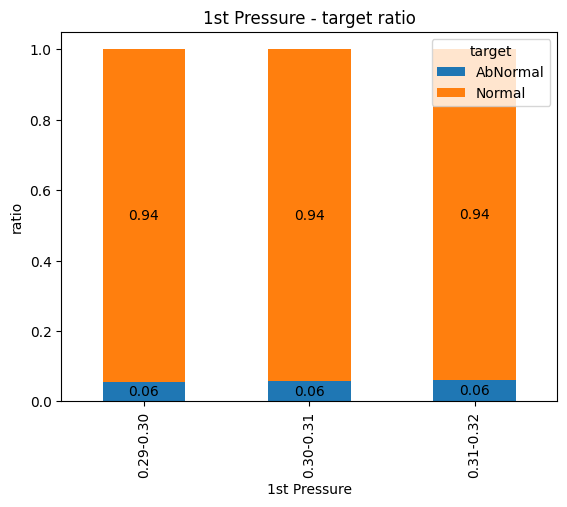

In [166]:
import pandas as pd
import matplotlib.pyplot as plt

# 1st Pressure 값을 구간으로 나누기
bins = [0.29, 0.30, 0.31, 0.32]
labels = ['0.29-0.30', '0.30-0.31', '0.31-0.32']
train_data['Pressure_Bin'] = pd.cut(train_data['1st Pressure Collect Result_AutoClave'], bins=bins, labels=labels, include_lowest=True)

# 각 구간에 대해 Normal과 abNormal의 비율 계산
pressure_target_counts = train_data.groupby('Pressure_Bin')['target'].value_counts(normalize=True).unstack()

# 막대그래프로 시각화
ax = pressure_target_counts.plot(kind='bar', stacked=True)
plt.xlabel('1st Pressure')
plt.ylabel('ratio')
plt.title('1st Pressure - target ratio')
plt.legend(title='target')

# 비율 수치 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center')

plt.show()

각 구간에 대한 타겟 변수의 갯수:
target        AbNormal  Normal
Pressure_Bin                  
0.2-0.3             79    1549
0.3-0.4           1242   18853
0.4-0.5            883   15890
0.5-0.6            146    1814
0.6-0.7              0      19
0.7-0.8              0       5
0.8-0.9              0      26


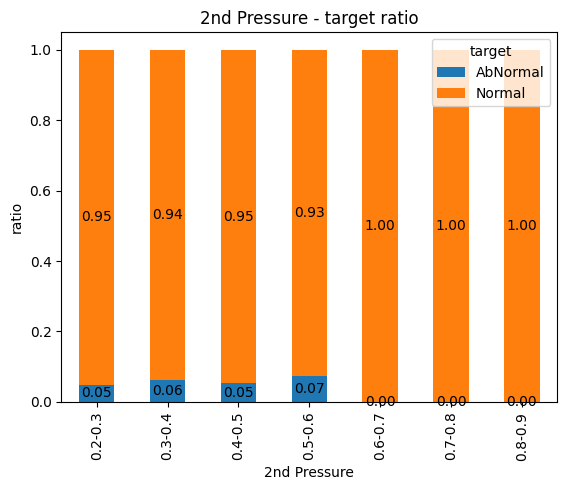

In [167]:
import pandas as pd 
import matplotlib.pyplot as plt

# 2nd Pressure 값을 구간으로 나누기
bins = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 
labels = ['0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9'] 
train_data['Pressure_Bin'] = pd.cut(train_data['2nd Pressure Collect Result_AutoClave'], bins=bins, labels=labels, include_lowest=True)

# 각 구간에 대해 Normal과 abNormal의 비율 계산
pressure_target_counts = train_data.groupby('Pressure_Bin')['target'].value_counts(normalize=True).unstack(fill_value=0)

# 각 구간에 대해 Normal과 abNormal의 갯수 계산
pressure_target_total_counts = train_data.groupby('Pressure_Bin')['target'].value_counts().unstack(fill_value=0)

# 갯수 출력
print("각 구간에 대한 타겟 변수의 갯수:")
print(pressure_target_total_counts)

# 막대그래프로 시각화
ax = pressure_target_counts.plot(kind='bar', stacked=True) 
plt.xlabel('2nd Pressure') 
plt.ylabel('ratio') 
plt.title('2nd Pressure - target ratio') 
plt.legend(title='target')

# 비율 수치 표시
for p in ax.patches: 
    width, height = p.get_width(), p.get_height() 
    x, y = p.get_xy() 
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center')

plt.show()

In [168]:
train_data['2nd_Pressure_Greater_Than_0.6'] = train_data['2nd Pressure Collect Result_AutoClave'].apply(lambda x: 1 if x >= 0.6 else 0)
test_data['2nd_Pressure_Greater_Than_0.6'] = test_data['2nd Pressure Collect Result_AutoClave'].apply(lambda x: 1 if x >= 0.6 else 0)

각 구간에 대한 타겟 변수의 갯수:
target        AbNormal  Normal
Pressure_Bin                  
0.3-0.4             31     307
0.4-0.5           1863   31682
0.5-0.6            433    6041
0.6-0.7             23      95
0.7-0.8              0       5
0.8-0.9              0       2
0.9-1                0      24


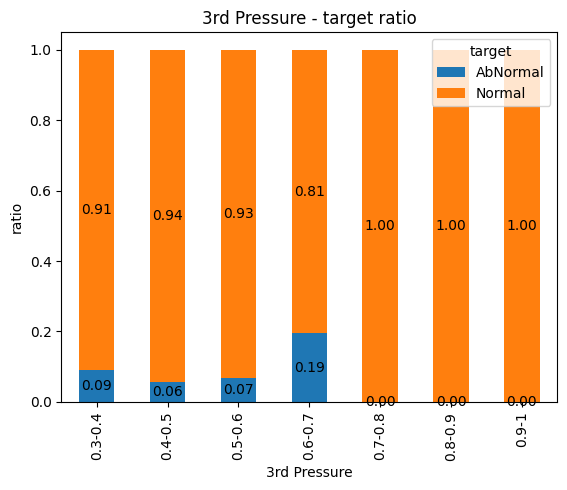

In [169]:
import pandas as pd 
import matplotlib.pyplot as plt

# 3rd Pressure 값을 구간으로 나누기
bins = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = ['0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1']
train_data['Pressure_Bin'] = pd.cut(train_data['3rd Pressure Collect Result_AutoClave'], bins=bins, labels=labels, include_lowest=True)

# 각 구간에 대해 Normal과 abNormal의 비율 계산
pressure_target_counts = train_data.groupby('Pressure_Bin')['target'].value_counts(normalize=True).unstack(fill_value=0)

# 각 구간에 대해 Normal과 abNormal의 갯수 계산
pressure_target_total_counts = train_data.groupby('Pressure_Bin')['target'].value_counts().unstack(fill_value=0)

# 갯수 출력
print("각 구간에 대한 타겟 변수의 갯수:")
print(pressure_target_total_counts)

# 막대그래프로 시각화
ax = pressure_target_counts.plot(kind='bar', stacked=True) 
plt.xlabel('3rd Pressure') 
plt.ylabel('ratio') 
plt.title('3rd Pressure - target ratio') 
plt.legend(title='target')

# 비율 수치 표시
for p in ax.patches: 
    width, height = p.get_width(), p.get_height() 
    x, y = p.get_xy() 
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center')

plt.show()

In [170]:
train_data['3rd_Pressure_Greater_Than_0.7'] = train_data['3rd Pressure Collect Result_AutoClave'].apply(lambda x: 1 if x >= 0.7 else 0)
test_data['3rd_Pressure_Greater_Than_0.7'] = test_data['3rd Pressure Collect Result_AutoClave'].apply(lambda x: 1 if x >= 0.7 else 0)

In [171]:
train_data['Chamber_Temp_multiply']  = train_data['Chamber Temp. Collect Result_AutoClave'] * train_data['Chamber Temp. Unit Time_AutoClave']
test_data['Chamber_Temp_multiply']  = test_data['Chamber Temp. Collect Result_AutoClave'] * test_data['Chamber Temp. Unit Time_AutoClave']

In [172]:
train_data['Chamber_Temp_multiply'].describe()

count    40506.000000
mean     21921.554041
std       3402.621983
min        147.000000
25%      19133.000000
50%      22560.000000
75%      25088.000000
max      31320.000000
Name: Chamber_Temp_multiply, dtype: float64

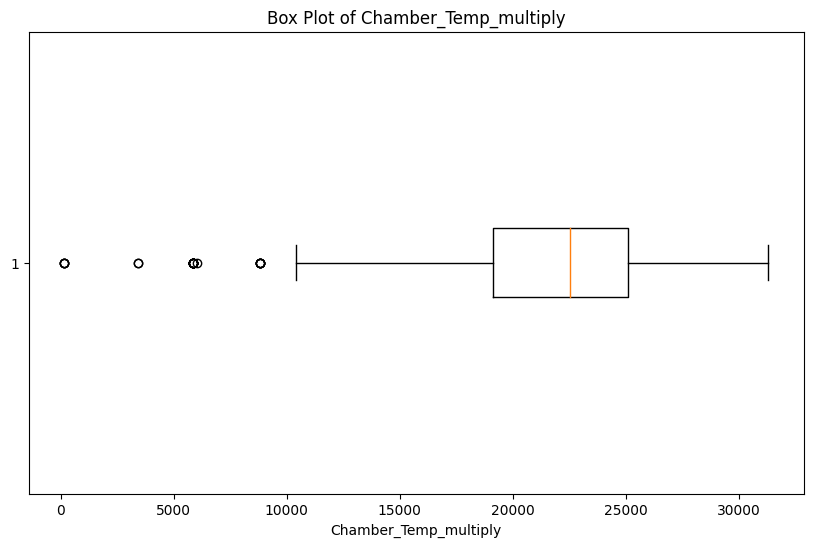

In [173]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임 예시 (실제 데이터로 대체하세요)
# train_data = pd.read_csv('your_data.csv')

# 박스 플롯 그리기
plt.figure(figsize=(10, 6))
plt.boxplot(train_data['Chamber_Temp_multiply'], vert=False)
plt.xlabel('Chamber_Temp_multiply')
plt.title('Box Plot of Chamber_Temp_multiply')
plt.show()

각 구간에 대한 타겟 변수의 갯수:
target        AbNormal  Normal
Pressure_Bin                  
0-5000               2       4
5000-10000          19       1
10000-15000         22      98
15000-20000        874   16711
20000-25000        773   11765
25000-30000        658    9558


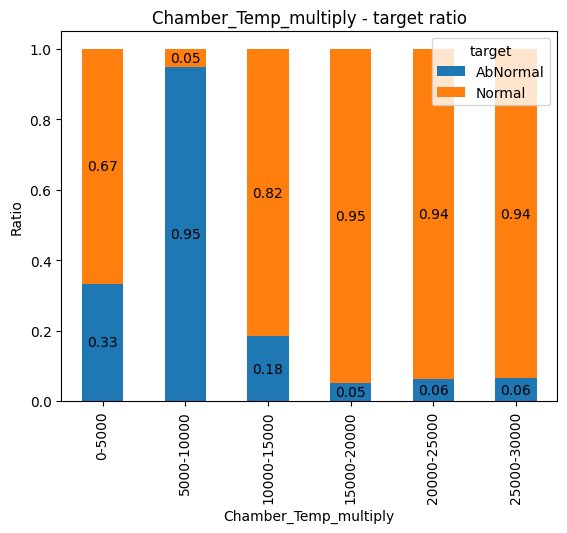

In [174]:
import pandas as pd
import matplotlib.pyplot as plt

# 기술 통계값을 기반으로 구간 설정
bins = [0, 5000, 10000, 15000, 20000, 25000, 30000]
labels = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000', '25000-30000']

# 1st_Pressure_multiply 값을 구간으로 나누기
train_data['Pressure_Bin'] = pd.cut(train_data['Chamber_Temp_multiply'], bins=bins, labels=labels, include_lowest=True)

# 각 구간에 대해 Normal과 abNormal의 비율 계산
chamber_target_counts = train_data.groupby('Pressure_Bin')['target'].value_counts(normalize=True).unstack(fill_value=0)

# 각 구간에 대해 Normal과 abNormal의 갯수 계산
chamber_target_counts_counts = train_data.groupby('Pressure_Bin')['target'].value_counts().unstack(fill_value=0)

# 갯수 출력
print("각 구간에 대한 타겟 변수의 갯수:")
print(chamber_target_counts_counts)

# 막대그래프로 시각화
ax = chamber_target_counts.plot(kind='bar', stacked=True)
plt.xlabel('Chamber_Temp_multiply')
plt.ylabel('Ratio')
plt.title('Chamber_Temp_multiply - target ratio')
plt.legend(title='target')

# 비율 수치 표시
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}', ha='center', va='center')

plt.show()


In [175]:
train_data['Chamber_Temp_multiply_smaller_Than_15000'] = train_data['Chamber_Temp_multiply'].apply(lambda x: 1 if x < 15000 else 0)
test_data['Chamber_Temp_multiply_smaller_Than_15000'] = test_data['Chamber_Temp_multiply'].apply(lambda x: 1 if x < 15000 else 0)

In [176]:
train_data = train_data.drop(columns=['Chamber_Temp_multiply'])
test_data = test_data.drop(columns=['Chamber_Temp_multiply'])

In [177]:
train_data['Chamber Temp. Judge Value_AutoClave'].value_counts()

OK    29112
NG    11394
Name: Chamber Temp. Judge Value_AutoClave, dtype: int64

In [178]:
grouped_counts = train_data.groupby(['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave', 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave']).size()
print(grouped_counts)

GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave  GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave
OK                                                    OK                                                   11293
dtype: int64


In [179]:
train_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].value_counts()

OK    11293
Name: GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave, dtype: int64

In [180]:
train_data['GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'].value_counts()

OK    11293
Name: GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave, dtype: int64

In [181]:
# GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave 이름을 GMES_ORIGIN_INSP_JUDGE_CODE_ok로 변경
train_data = train_data.rename(columns={'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave': 'GMES_ORIGIN_INSP_JUDGE_CODE_ok'})
test_data = test_data.rename(columns={'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave': 'GMES_ORIGIN_INSP_JUDGE_CODE_ok'})

# OK를 1로, 나머지 0으로 변경
train_data['GMES_ORIGIN_INSP_JUDGE_CODE_ok'] = train_data['GMES_ORIGIN_INSP_JUDGE_CODE_ok'].apply(lambda x: 1 if x == "OK" else 0)
test_data['GMES_ORIGIN_INSP_JUDGE_CODE_ok'] = test_data['GMES_ORIGIN_INSP_JUDGE_CODE_ok'].apply(lambda x: 1 if x == "OK" else 0)

# 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave' 열 드롭
train_data = train_data.drop(columns=['GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'])
test_data = test_data.drop(columns=['GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'])

In [182]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 122 entries, Model.Suffix to Chamber_Temp_multiply_smaller_Than_15000
dtypes: category(1), float64(58), int64(56), object(7)
memory usage: 37.4+ MB


In [183]:
# train_data의 칼럼 이름 출력
print("train_data의 칼럼 이름:")
columns = train_data.columns.to_list()

# 한 줄에 3개의 변수씩 출력
for i in range(0, len(columns), 3):
    print(columns[i:i+3])

train_data의 칼럼 이름:
['Model.Suffix', 'Workorder', 'CURE END POSITION X Collect Result_Dam']
['CURE END POSITION Z Collect Result_Dam', 'CURE END POSITION ? Collect Result_Dam', 'CURE SPEED Collect Result_Dam']
['CURE START POSITION X Collect Result_Dam', 'CURE START POSITION ? Collect Result_Dam', 'DISCHARGED SPEED OF RESIN Collect Result_Dam']
['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']
['Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage2) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam']
['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam']
['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Res

In [184]:
train_data['Receip No Collect Result_Dam'].value_counts()

1     39280
6       980
9        96
17       86
3        64
Name: Receip No Collect Result_Dam, dtype: int64

In [185]:
train_data['Receip No Collect Result_Fill1'].value_counts()

1     39276
6       983
9        96
17       86
3        64
4         1
Name: Receip No Collect Result_Fill1, dtype: int64

In [186]:
train_data['Receip No Collect Result_Fill2'].value_counts()

1     39277
6       983
9        96
17       86
3        64
Name: Receip No Collect Result_Fill2, dtype: int64

In [190]:
# 세 개의 변수를 하나의 그룹으로 묶어 그룹별로 갯수 확인
grouped_counts = train_data.groupby(['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2']).size()

# 결과 출력
print("Grouped counts for Receip No Collect Result_Dam, Receip No Collect Result_Fill1, and Receip No Collect Result_Fill2:")
print(grouped_counts)

# 타겟 변수의 비율 계산
target_variable = 'target'  # 타겟 변수 이름을 여기에 입력하세요
grouped_target_counts = train_data.groupby(['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2'])[target_variable].value_counts(normalize=True).unstack().fillna(0)

# 타겟 변수의 비율 출력
print("\nGrouped target variable ratios for Receip No Collect Result_Dam, Receip No Collect Result_Fill1, and Receip No Collect Result_Fill2:")
print(grouped_target_counts)

Grouped counts for Receip No Collect Result_Dam, Receip No Collect Result_Fill1, and Receip No Collect Result_Fill2:
Receip No Collect Result_Dam  Receip No Collect Result_Fill1  Receip No Collect Result_Fill2
1                             1                               1                                 39276
                              4                               1                                     1
                              6                               6                                     3
3                             3                               3                                    64
6                             6                               6                                   980
9                             9                               9                                    96
17                            17                              17                                   86
dtype: int64

Grouped target variable ratios for Receip No Collect Result_Da

In [ ]:
train_data['Receip No Collect Result_Fill1'].value_counts()

In [807]:
# 'Pressure_Bin' 열 드롭 / test_data는 생성되지 않았으므로 드롭하지 않음
train_data = train_data.drop(columns=['Pressure_Bin'])

### 언더 샘플링


데이타 불균형을 해결하기 위해 언더 샘플링을 진행합니다.


In [808]:
train_data['target'].value_counts()

Normal      38156
AbNormal     2350
Name: target, dtype: int64

In [810]:
normal_ratio = 1.0  # 1.0 means 1:1 ratio

df_normal = train_data[train_data["target"] == "Normal"]
df_abnormal = train_data[train_data["target"] == "AbNormal"]

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target")

  Total: Normal: 38156, AbNormal: 2350


target
AbNormal    2350
Normal      2350
dtype: int64

### 데이터 분할


In [811]:
df_train, df_val = train_test_split(
    df_concat,
    test_size=0.2,
    stratify=df_concat["target"],
    random_state=RANDOM_STATE,
)


def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 1880, AbNormal: 1880 ratio: 1.0
  Total: Normal: 470, AbNormal: 470 ratio: 1.0


## 3. 모델 학습


### 모델 정의


In [812]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

### 모델 학습


In [813]:
features = []

for col in df_train.columns:
    try:
        df_train[col] = df_train[col].astype(int)
        features.append(col)
    except:
        continue

train_x = df_train[features]
train_y = df_train["target"]

model.fit(train_x, train_y)

RandomForestClassifier(random_state=110)

## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [821]:
# test_data에 존재하는 열만 선택
valid_features = [col for col in features if col in test_data.columns]

df_test_x = test_data.loc[:, valid_features]

for col in df_test_x.columns:
    try:
        df_test_x.loc[:, col] = df_test_x[col].astype(int)
    except:
        continue

In [823]:
# 학습 시 사용된 피처 이름을 저장합니다.
train_features = model.feature_names_in_

# 예측 시 동일한 피처를 사용하도록 데이터프레임을 조정합니다.
df_test_x = df_test_x.reindex(columns=train_features, fill_value=0)

# 예측을 수행합니다.
test_pred = model.predict(df_test_x)
test_pred

array(['AbNormal', 'AbNormal', 'AbNormal', ..., 'AbNormal', 'Normal',
       'AbNormal'], dtype=object)

### 제출 파일 작성


In [825]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
